## Installation

In [4]:
# # install package dependencies Seurat, scLink and dplyr
# install.packages('scLink',version='1.0.1')
# install.packages('dplyr')
# remotes::install_version("Seurat", "4.4.0")

In [5]:
# library(devtools)
# install_github("KChen-lab/transition-cells-identification",force=T)

In [6]:
library(CellTran)
options(warn=-1)

## Read data

,orig.ident,nCount_RNA,nFeature_RNA,ClusterName
,<fct>,<dbl>,<int>,<chr>
Mix-1:AAAGCAACACTTCGAAx,SeuratProject,148.9997,156,3d
Mix-1:AACTCTTCACAGCCCAx,SeuratProject,140.1297,134,3d
Mix-1:AAGCCGCAGGAATCGCx,SeuratProject,136.2231,148,3d
Mix-1:ACACTGAGTAACGCGAx,SeuratProject,135.8862,142,3d
Mix-1:ACACTGATCAACGCTAx,SeuratProject,142.1270,137,3d
Mix-1:ACCTTTACAGACACTTx,SeuratProject,120.3248,87,3d


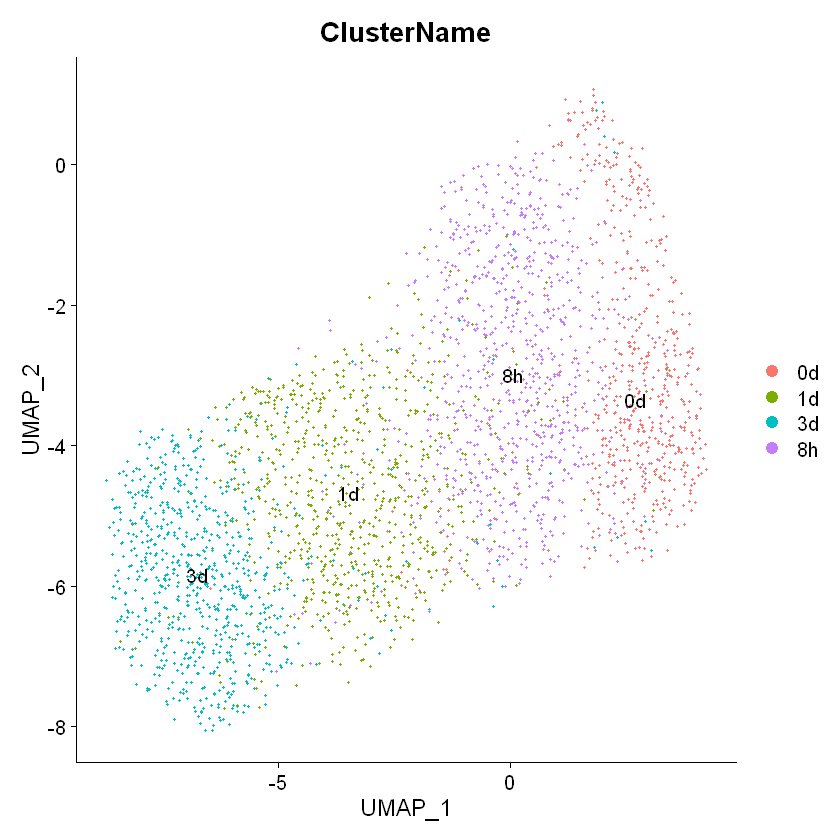

In [7]:
library(Seurat)
library(dplyr)

data_name = 'A549'

# (1) 读取表达矩阵（自动生成行名 "1", "2", "3"...）
counts <- read.csv(paste(data_name, "X.csv", sep = "/"), row.names = 1)  # 假设第一列是基因名

# (2) 创建 Seurat 对象
data <- CreateSeuratObject(
  counts = t(counts),          # Seurat 要求行=基因，列=细胞（需转置）
)

# (3) 添加 PCA 坐标
pca <- read.csv(paste(data_name, "pca.csv", sep = "/"), row.names = 1)
data[["pca"]] <- CreateDimReducObject(
  embeddings = as.matrix(pca), # PCA 坐标矩阵
  key = "PC_",                 # 坐标列名前缀（如 PC_1, PC_2）
  assay = "RNA"                # 关联到 RNA assay
)

# (4) 添加 UMAP 坐标
umap <- read.csv(paste(data_name, "umap.csv", sep = "/"), row.names = 1)
data[["umap"]] <- CreateDimReducObject(
  embeddings = as.matrix(umap),
  key = "UMAP_",               # 坐标列名前缀（如 UMAP_1, UMAP_2）
  assay = "RNA"
)

# (5) 添加聚类标签
clusters <- read.csv(paste(data_name, "ClusterName.csv", sep = "/"), row.names = 1)
data <- AddMetaData(
  object = data,
  metadata = clusters,
  col.name = "ClusterName"     # 元数据列名
)

# (6) 设置默认聚类标识
Idents(data) <- "ClusterName"  # 后续分析默认按此分组

# 查看结果
head(data@meta.data)
DimPlot(data, reduction = "umap", group.by = "ClusterName", label = TRUE)

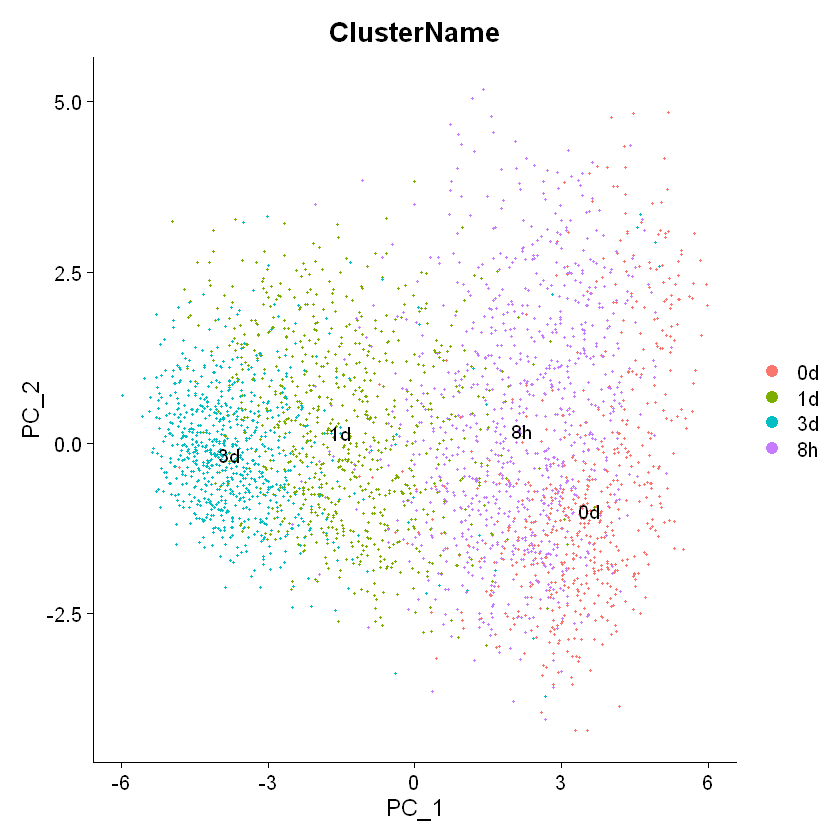

In [8]:
DimPlot(data, reduction = "pca", group.by = "ClusterName", label = TRUE)

In [9]:
data<- NormalizeData(data)
data<- ScaleData(data)
# data<- RunPCA(data, features = rownames(data))
data<- FindNeighbors(data, dims = 1: 5)
data<- FindClusters(data, resolution = 0.5)
# data<- RunUMAP(data,dims=1:5)

Centering and scaling data matrix

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2961
Number of edges: 88538

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8129
Number of communities: 6
Elapsed time: 0 seconds


In [10]:
data

An object of class Seurat 
437 features across 2961 samples within 1 assay 
Active assay: RNA (437 features, 0 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap

# Calculate transition index

In [11]:
#' Calculate GPPCCs
#'
#' This is the function calculating gene pair-wise Pearson's correlation coefficients (GPPCCs). 
#' The GPPCCs calculated using our method are assumed from the cells that exhibit similar 
#' regulatory profiles and around equilibrium points. Thus, for each cell, we select the cell 
#' together with its nearest neighbors in Principal Component Analysis (PCA) dimensions based 
#' on cosine distance to calculate GPPCCs. We also use scLink in the calculation to deal with
#' the gene expression values affected by dropout. 
#' @param data Seurat object containing both count matrix and metadata such as neighboring 
#' results for a single-cell dataset.
#' @param highly_variable_gene A gene list containing top most variable genes. Calculated 
#' by \code{var} function by default.
#' @param n_neighbor The number of neighboring cells used to calculate GPPCCs. 300 by default.
#' @return A matrix of GPPCCs. Rows are cells and columns are gene pairs.
#' @import Seurat
#' @import scLink
#' @import dplyr
#' @export
gene_pearson<-function(data,highly_variable_gene=NULL,n_neighbor=300,n_gene=50,...){
        res<-NULL
        exprs<-as.matrix(GetAssayData(data))
        if(is.null(highly_variable_gene)){
                highly_variable_gene<-order(apply(as.matrix(exprs),1,function(x) var(x)),decreasing=T)[1:n_gene]
                highly_variable_gene<-rownames(exprs)[highly_variable_gene]
        }
        for(c in data %>% colnames()){
                expr<-t(exprs[highly_variable_gene,data@neighbors$RNA.nn@nn.idx[match(c,data@neighbors$RNA.nn@cell.names),]])
                pearson_cor<-scLink::sclink_cor(expr = expr, ncores = 1)
                diag(pearson_cor)<-NA
                res<-rbind(res,as.numeric(pearson_cor))
        }
        rownames(res)<-colnames(data)
        gene_name<-highly_variable_gene
        name_tmp<-character()
        for(i in gene_name){
                for(j in gene_name)
                        name_tmp<-c(name_tmp,paste(i,j,sep='_'))
         }
        colnames(res)<-name_tmp
        return(res)
}


find_ks_d<-function(x,y){
        n.x <- length(x)
        n.y <- length(y)
        w <- c(x, y)
        z <- cumsum(ifelse(order(w) <= n.x, 1/n.x, -1/n.y))
        w_sort<-sort(w)
        w_max<-max(w_sort[z==max(z)])
        z_sub<-z[w_sort>w_max]
        w_min<-min(w_sort[w_sort>w_max][z_sub==min(z_sub)])
        return(list('w_min'=w_min,'w_max'=w_max))
}

#' Calculate transition index
#'
#' This is the function calculating transition index that reflects the transition
#' probability of a cell. The transition index we defined is inspired by Kolmogorov-Smirnov 
#' statistic. We assume there are both transition cells and stable cells captured by  
#' scRNA-seq in the data. We first find the archetype of transition 
#' cell and stable cell by using modified Kolmogorov-Smirnov statistic. As proved 
#' mathematically, there are more gene pairs whose absolute value of Pearson鈥檚 
#' correlation coefficients are close to 1 in transition cells than stable cells. 
#' Thus, based on the distribution difference, by finding the maximum difference 
#' among all cells, we identify archetypal stable cells and transition cells. To 
#' count and compare the number of gene pairs exceeding such threshold in each cell, 
#' we define transition index by summarizing the percentage of gene pairs whose 
#' absolute value of Pearson鈥檚 correlation coefficients are between argmax_x(D_max)    
#' and argmin_x(D_max). 
#'
#' @param data Seurat object containing both count matrix and metadata such as neighboring 
#' results for a single-cell dataset.
#' @param highly_variable_gene A gene list containing top most variable genes. Calculated 
#' by \code{var} function by default.
#' @param group The cell group highly_variable_genes selected based on. It should be a column
#' name of data@meta.data, such as 'seurat_clusters','cell_type','time_point'. Using 
#' 'seurat_clusters' by default. 
#' @param n_neighbor The number of neighboring cells used to calculate GPPCCs. 300 by default.
#' @param n_gene The number of top most variable genes used in calculating GPPCCs. 50 by default.
#' @param return_pearson Whether report GPPCCs or not. Using False by default.
#' @return If return_pearson is False, return a Seurat object. Calculated transition index is 
#' store as a column in the metadata. If return_pearson is True, return a list. Calculated 
#' transition index is stored in the data element, as a column in the metadata. GPPCCs is stored
#' in the GPPCCs element.
#' @import Seurat
#' @import scLink
#' @import dplyr
#' @export
transition_index<-function(data,highly_variable_gene=NULL,group='seurat_clusters',n_neighbors=300,n_gene=50,return_pearson=FALSE,...){
    res<-list()
    for(i in data@meta.data[,group] %>% unique()){
            print(i)
            data_sub<-data[,data@meta.data[,group]==i]
            if(ncol(data_sub)<=n_neighbors)
                    next
            data_sub<-Seurat::FindVariableFeatures(data_sub, selection.method = "vst", nfeatures = 2000)
            data_sub<- Seurat::ScaleData(data_sub,vars.to.regress="nCount_RNA")
            data_sub<- Seurat::RunPCA(data_sub, features = VariableFeatures(object = data_sub),npcs=min(20,ncol(data_sub)))
            data_sub<- Seurat::FindNeighbors(data_sub, dims = 1: min(20,ncol(data_sub)),return.neighbor = TRUE,k.param=n_neighbors,annoy.metric='cosine')
            pearson<-gene_pearson(data_sub,highly_variable_gene=highly_variable_gene,n_neighbor=n_neighbors,n_gene=n_gene)
            # fine tuning  (optional)
            pearson<-abs(pearson)
            res_1<-apply(pearson,1,function(x) ks.test(x,pearson[1,],alternative='greater')$statistic)
            res_2<-apply(pearson,1,function(x) ks.test(x,pearson[1,],alternative='less')$statistic)
            res_tmp<-find_ks_d(pearson[which.max(res_1),],pearson[which.max(res_2),])
            tmp<-apply(pearson,1,function(x) sum(abs(x)>min(unlist(res_tmp)) & abs(x)<max(unlist(res_tmp)),na.rm=T)/sum(abs(x)>=0,na.rm=T))
            data_sub<-Seurat::AddMetaData(data_sub,data.frame('pearson'=tmp))
            if(min(tmp)==max(tmp)){
                    res[[as.character(i)]]<-pearson
                    next
            }
            cell<-data_sub@meta.data %>% dplyr::filter(pearson>quantile(data_sub$pearson,0.8,na.rm=T)) %>% rownames()
            hvg<-sort(apply(as.matrix(GetAssayData(data_sub[,cell])),1,function(x) var(x)),decreasing=T)[1:n_gene] %>% names
            pearson<-gene_pearson(data_sub,n_neighbor=n_neighbors,highly_variable_gene=hvg)
            res[[as.character(i)]]<-pearson
    }
    res<-Reduce(function(x,y) rbind(x,y),res)
    pearson<-res
    res<-abs(res)
    res_1<-apply(res,1,function(x) ks.test(x,res[1,],alternative='greater')$statistic)
    res_2<-apply(res,1,function(x) ks.test(x,res[1,],alternative='less')$statistic)
    res_tmp<-find_ks_d(res[which.max(res_1),],res[which.max(res_2),])
    tmp<-apply(res,1,function(x) sum(abs(x)>min(unlist(res_tmp)) & abs(x)<max(unlist(res_tmp)),na.rm=T)/sum(abs(x)>=0,na.rm=T))
    data<-Seurat::AddMetaData(data,data.frame('transition_index'=tmp))
    if(!return_pearson)
    return(data)
    else
    return(list('GPPCCs'=pearson,'data'=data))
}


In [12]:
# calculate transition index
data<-transition_index(data,n_neighbor=50,n_gene=100)

[1] "0"


Regressing out nCount_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  NQO1, TUBA4A, AKR1B1, ANXA3, TPM1, EBNA1BP2, ECH1, UBE2T, NNMT, TM4SF1 
	   RSU1, C1QBP, GLA, TNFAIP6, TPM2, AKR1C3, GCLM, EZR, TXNRD2, MORF4L2 
	   CYCS, CADM1, PGD, CCND3, TKT, TMEM59, COTL1, TAGLN, CA8, SQSTM1 
Negative:  TIMP2, FN1, COL4A2, NFKBIZ, ITGA11, ZFP36L1, FOXP1, MLXIP, PMEPA1, CCDC80 
	   CXCL8, SLN, BTG1, COL5A1, RP11.631N16.2, THBS1, JARID2, COL4A1, SEMA3C, WNT7A 
	   QKI, TGFBI, ADAMTS6, COL5A2, SKIL, RNF11, GAL, EMP1, KDM6B, ABLIM3 
PC_ 2 
Positive:  LAMC2, WNT7A, FOXP1, COTL1, BCL2A1, RGS3, MOB3B, FRMD6, PDLIM7, PSMD2 
	   KCNMA1, FXYD5, IL11, OCIAD2, MBOAT2, CCND1, ZNF185, NT5E, CREM, SMS 
	   CCDC80, SERPINE2, TSPAN4, TAGLN, GLIPR1, SH3KBP1, LMCD1, FSTL1, TRMT13, DNER 
Negative:  CPLX2, ALDH3A1, GPX2, COL5A2, ELF3, ANXA13, RDX, DIO2, GPRC5A, C9orf3 
	   RHOF, TGFBI, ST3GAL5, NCOA7, TIMP2, MYOCD, MTUS1, ITGA11, TNS3, ITGB5 
	   FGL1, AGR2, TNFAIP8, PERP, HSPB1, SLC7A11, PLAC8, GDF15, PGM

[1] "1"


Regressing out nCount_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  CPLX2, FN1, ITGA11, ALDH3A1, CCDC80, ELF3, SLN, USH1C, QPCT, GPX2 
	   HPGD, TGFBI, SERPINE2, EPHX1, BTG1, MMP2, SGCA, AGR2, MTUS1, SLC2A1 
	   RASGRP3, TNS1, HTRA1, AKR1C1, COL5A1, WNT5B, RAET1G, INPP4B, LTBP3, ABLIM3 
Negative:  COTL1, HMGA1, PAQR5, CYCS, BCL2A1, CAV1, CTNNAL1, ID3, CHCHD10, UBE2T 
	   PRRT3.AS1, AVPI1, LAMC2, PPP1R14A, EBNA1BP2, C1QBP, UPP1, WNT7B, EZR, CDC25B 
	   GPATCH4, NEK6, KCNMA1, TSPAN4, FRMD6, AHNAK, NCOA3, DDB2, MT2A, RHOF 
PC_ 2 
Positive:  LAMC2, IL11, COL4A1, TNFAIP6, COL4A2, FOXP1, KCNMA1, WNT7A, RASGRP3, SERPINE2 
	   GAL, VCAN, BCL2A1, AC006262.4, FXYD5, GLIPR1, MBOAT2, RGS3, CCDC80, MT2A 
	   OCIAD2, CCBE1, PAPPA, GADD45A, LMCD1, CXCL8, DDB2, SYT13, CYR61, ZNF185 
Negative:  ELF3, C9orf3, TM4SF20, GPX2, MYOCD, MYOF, LGR4, NCOA3, ST3GAL5, UPP1 
	   GPRC5A, CSGALNACT1, CA12, DIO2, PMP22, STOM, GACAT2, CAV1, AKR1C3, ITGB5 
	   SLC2A1, TJP1, FGD4, AMIGO2, RBFOX3, SKIL, NCOA7

[1] "2"


Regressing out nCount_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  ID3, RTN4RL2, PLAC8, UPP1, BLVRB, EBNA1BP2, C1QBP, ADM, SLC7A5, CCND3 
	   PGD, NDUFAB1, AREG, PERP, NQO1, HMGCS1, PMP22, ABCG2, TXNRD1, TRIML2 
	   GPATCH4, NTN4, CHPT1, ISG20, AKR1C2, RBFOX3, B4GALT4, FYB, TESC, RGS20 
Negative:  CCDC80, LAMC2, MT2A, PLEK2, IGFBP7, TGFBI, GLIPR1, PODXL, OCIAD2, SERPINE2 
	   COL5A1, MARCH4, NT5E, TPM1, SYT13, PDLIM7, FRMD6, COL4A2, AKR1B1, MBOAT2 
	   COL4A1, SLC22A3, ZNF185, UBR4, IL15, TAGLN, PHLDB2, MMP2, TNS1, ABLIM3 
PC_ 2 
Positive:  TUBA4A, NQO1, NDUFAB1, AKR1B1, ANXA3, TPM2, SERPINE2, EZR, PGD, AKR1C3 
	   PERP, ECH1, EPHX1, GLA, BLVRB, VIM, TMEM59, ALDH3A1, C1QBP, GADD45A 
	   PSMD2, RDX, CTNNAL1, BCL2A1, NTHL1, GCLM, SRGN, EBNA1BP2, TKT, CYR61 
Negative:  NCOA3, PMEPA1, TNRC6C, VGLL3, NPTX1, TJP1, TNS3, COL5A2, CAMK2D, SKIL 
	   PHLDB1, NKAIN4, ITGB5, SLC7A5, EMP1, LGR4, NUAK1, CEPT1, C9orf3, GPX2 
	   NCEH1, ABLIM3, FIBCD1, HMGA1, CHST3, ELF3, UPP1, FN1, ITGB6,

[1] "4"


Regressing out nCount_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  AGR2, GPX2, TSPAN4, BLVRB, CYCS, PLA2G16, TM4SF20, TKT, NQO1, AKR1C3 
	   AREG, CDC25B, TESC, ALDH3A1, UBE2T, AKR1C2, NDUFAB1, PMP22, RTN4RL2, ISG20 
	   GCLM, SQSTM1, HMGA1, NTHL1, SRGN, THOC6, AKR1C1, SLC9A3R1, CCND1, EZR 
Negative:  NPTX1, COL5A1, FSTL1, IGFBP7, TGFBI, TNS1, CCDC80, TIMP2, ITGA11, GLIPR1 
	   CDH2, PODXL, CMTM3, AC006262.4, SLN, SERPINE2, PAPPA, KCNJ6, TNS3, BTG1 
	   SEMA3C, CREM, COL5A2, NAV1, COL4A1, COL4A2, FIBCD1, INPP4B, VPS13B, TIMP3 
PC_ 2 
Positive:  NPTX1, CAV1, ID3, TJP1, MAP3K8, CREM, RAET1G, NKAIN4, SLC7A5, BORA 
	   ANKRD2, RGS20, MEG3, CHPT1, NTN4, B4GALT4, TRIM9, MYOCD, GPATCH4, TPM1 
	   CERCAM, CCND3, LHX8, CDK6, CSGALNACT1, TXNRD1, N4BP2L2, MEIOB, C1QBP, SPOCK1 
Negative:  AGR2, EPHX1, GPX2, SYT13, AKR1C1, ALDH3A1, FN1, PLXNA2, ANXA13, PDLIM7 
	   SERPINE2, HPGD, MT2A, TMEM156, KDM6B, CXCL8, CA12, IGFBP6, CCDC80, DPYSL3 
	   MGLL, FXYD5, AKR1B1, FCGBP, WIPF1, QPCT, USH

[1] "3"


Regressing out nCount_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  TGFBI, PLEK2, AKR1B1, HMGA1, IGFBP7, COTL1, MT2A, ZFP36L1, GADD45A, GLIPR1 
	   ANXA3, SH3KBP1, OCIAD2, KCNMA1, CAV1, MGLL, TPM1, TRIM47, EVA1C, RSPO3 
	   F12, BCL2A1, NAV2, ARHGAP29, MITF, PODXL, CXCL8, UBR4, LAMC2, SERPINE2 
Negative:  ELF3, ITGB5, CCND3, RTN4RL2, GDF15, COL5A2, SLC7A5, NCOA3, NR0B1, ABCG2 
	   PLAC8, ADM, NCOA7, ISG20, TXNRD1, PLA2G16, NDUFAB1, FYB, B4GALT4, AGR2 
	   SQSTM1, MAP3K8, BLVRB, ID3, CYP4F11, UPP1, MYOCD, FGL1, CAPN12, RNF38 
PC_ 2 
Positive:  NQO1, TPM2, C1QBP, ECH1, AKR1B1, UBE2T, ALDH3A1, TKT, TM4SF1, EZR 
	   SQSTM1, MRPS18C, TUBA4A, TSPAN4, TMEM59, ANXA3, NTHL1, TESC, VIM, NR0B1 
	   GCLM, BLVRB, EBNA1BP2, RSU1, EPHX1, PGD, CCND1, FXYD5, AKR1C1, NDUFAB1 
Negative:  PMEPA1, AMIGO2, JAG1, NAV1, THBS1, ZFP36L1, COL5A2, CDH2, MT2A, FRMD6 
	   FN1, COL5A1, CAV1, SERPINE1, ITGB5, SYT13, LIPH, CCDC80, GNG4, MYOF 
	   ARSB, NPTX1, CDK6, SUN1, HIP1, PHLDB2, FBXO32, GPX2, GACAT2,

[1] "5"


Regressing out nCount_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  AKR1B1, PLA2G4A, SRSF1, ZC3H12C, KCNJ6, SBNO2, AC006262.4, TNFAIP2, BMP1, SERPINE2 
	   FN1, MATN2, COL5A2, NFKBIZ, PMEPA1, ITGAV, CXCL8, AP1S3, MAML2, PAPPA 
	   ANKRD30A, ALDH3A1, NAV2, MOB3B, DPYSL3, ITGA1, SLC22A3, SEMA3C, ADAMTS10, ZFP36L1 
Negative:  EBNA1BP2, AVPI1, C1QBP, AREG, TSPAN4, SH2D4A, BORA, B4GALT4, SLC9A3R1, CYCS 
	   PPP1R14A, ANKRD2, NR0B1, UBE2T, RP9, TM4SF1, ABCG2, GCLM, TESC, ISG20 
	   BLOC1S2, GLA, COTL1, PDGFC, TUBA4A, MMP24, GPATCH4, MRPS18C, AHNAK, MLXIP 
PC_ 2 
Positive:  ZC3H12C, SRSF1, KCNJ6, AP1S3, NAV2, ST6GAL2, ANKRD30A, AC006262.4, BMP1, PODXL 
	   NFKBIZ, UBE2T, NDRG1, PLAC8, PER2, COTL1, SLC7A5, CYCS, SLC7A11, SEMA3C 
	   HAS2, AHNAK, VGLL3, PMEPA1, CSGALNACT1, C1QBP, CA8, PLA2G16, ADD3, MT2A 
Negative:  EPHX1, TM4SF1, FGL1, TPM2, ID3, SH3RF2, CNTNAP3B, HABP4, DUSP4, TRIM47 
	   ANXA13, NR4A2, ALDH3A1, SERPINE2, FXYD5, AKR1C1, PGM2L1, CXCL8, QPCT, ANXA3 
	   TNS1, ARL15,

##Visualization

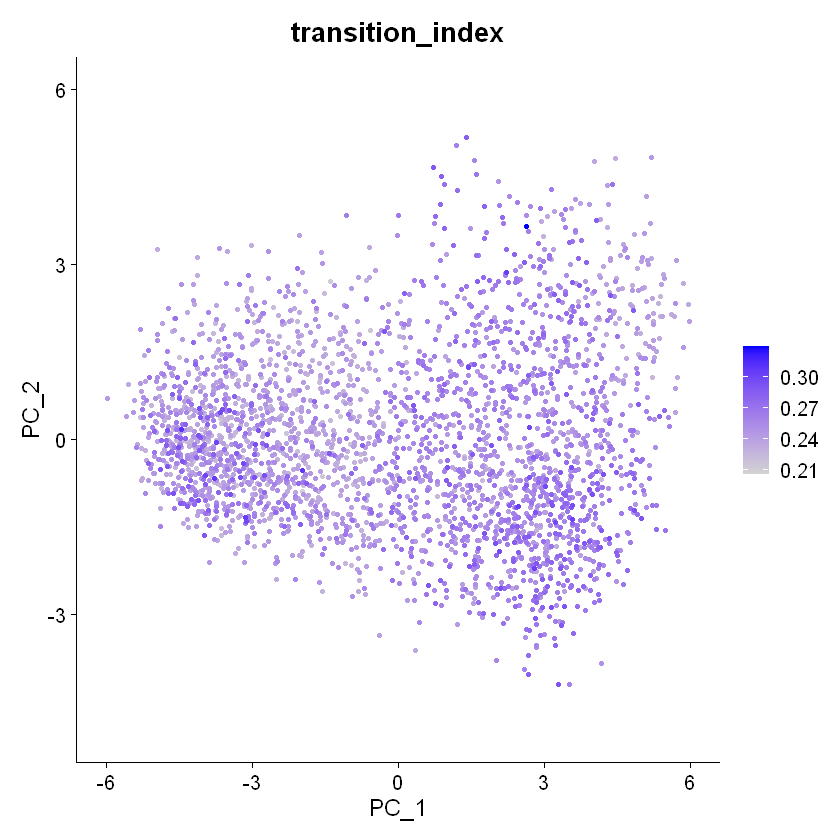

In [13]:
# UMAP 按 Transition Index 着色
FeaturePlot(data, reduction = "pca", features = 'transition_index', order = TRUE, pt.size = 1)

In [15]:
write.table(data$transition_index, 
            file = paste(data_name,"transition_index.csv",sep='/'),
            row.names = FALSE,
            col.names = FALSE,
            sep = ",")